In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly
from IPython.display import display

# Measuring Drift

we have 2 parts of the data, the ongoing *data* which we want to monitor for changes and the *baseline* data which was used to train the model and serve as the anchor and represent the expected distribution.
* baseline: 153,870 records over 31 days (2020-01-18 - 2020-02-17)
* ongoing data: 544,952 records over 117 days (2020-02-18 - 2020-06-12)

we have 61 features, named *'f1'* - *'f61'*:
* 32 numeric features: f1 - f32
* 13 categorical features: f33 - f45
* 16 binary features): f46 - f61

# Load data

In [2]:
# fpath = 'baseline.pkl'
fpath = 'https://superwise-public.s3.amazonaws.com/baseline.pkl'
baseline = pd.read_pickle(fpath)

display(baseline['date'].agg(['min', 'max']))
print(baseline.shape)
baseline.head(1)

min   2020-01-18
max   2020-02-17
Name: date, dtype: datetime64[ns]

(153870, 64)


date  prediction_probability  label   f1   f2   f3   f4   f5   f6  \
id                                                                             
3001 2020-01-18                0.002053    0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       f7  ...  f52  f53  f54  f55  f56  f57  f58  f59  f60  f61  
id         ...                                                    
3001  0.0  ...    1  0.0  0.0    0  0.0    0    0  0.0    0    0  

[1 rows x 64 columns]

In [3]:
fpath = 'data.pkl'
fpath = 'https://superwise-public.s3.amazonaws.com/data.pkl'
data = pd.read_pickle(fpath)
print(data.shape)
display(data['date'].agg(['min', 'max']))
data.head(2)

(544950, 64)


min   2020-02-18
max   2020-06-12
Name: date, dtype: datetime64[ns]

date  prediction_probability  label   f1   f2   f3   f4   f5  \
id                                                                           
1494010 2020-02-20                0.000977    0.0  0.0  0.0  0.0  0.0  1.0   
1494050 2020-02-25                0.048037    0.0  0.0  0.0  1.0  2.0  2.0   

          f6   f7  ...  f52  f53  f54  f55  f56  f57  f58  f59  f60  f61  
id                 ...                                                    
1494010  2.0  1.0  ...    1  0.0  0.0    0  0.0    0    0  0.0    0    0  
1494050  4.0  1.0  ...    0  0.0  0.0    1  0.0    0    0  0.0    1    0  

[2 rows x 64 columns]

# Aggregate Univariate Metrics

We'll measure drifts per feature and aggregate these to single data drift measurement

## Single Feature Example

### Categorical Feature

In [4]:
feature = 'f42'

#### Simple statistics
* nunique
* most frequent percent
* Null values
* New values
* Entropy

In [5]:
feature_stats = data.groupby('date')[feature].agg(nunique = pd.Series.nunique,
                                                             most_freq_percent = lambda s: s.value_counts(normalize=True).iat[0],
                                                             entropy = lambda s: entropy(s.value_counts(normalize=True)))

feature_stats.head()

nunique  most_freq_percent   entropy
date                                            
2020-02-18        6           0.381999  1.559332
2020-02-19        6           0.374739  1.547643
2020-02-20        6           0.399604  1.535993
2020-02-21        6           0.499803  1.400839
2020-02-22        6           0.495537  1.409335

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

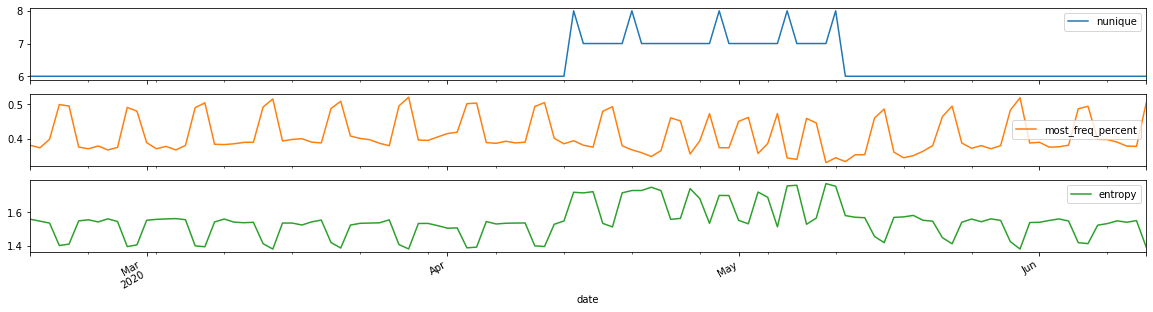

In [6]:
pd.options.plotting.backend = "matplotlib"

feature_stats.plot(subplots=True, figsize=(20, 5))

#### Changes in the data distribution - Chi Square

In [7]:
baseline_distribution = baseline[feature].value_counts(normalize=True, dropna=False)
baseline_distribution.head()

C0    0.390862
C6    0.211100
C1    0.158471
C7    0.152778
C2    0.050666
Name: f42, dtype: float64

In [8]:
from scipy.stats import chisquare

def categorical_chisquare(daily_obs, exp_dist=baseline_distribution):
    obs_dist = daily_obs.value_counts(normalize=True, dropna=False)
    obs_dist = obs_dist.reindex(exp_dist.index).fillna(0)
    r = chisquare(f_obs=obs_dist, f_exp=exp_dist)
    return r.statistic

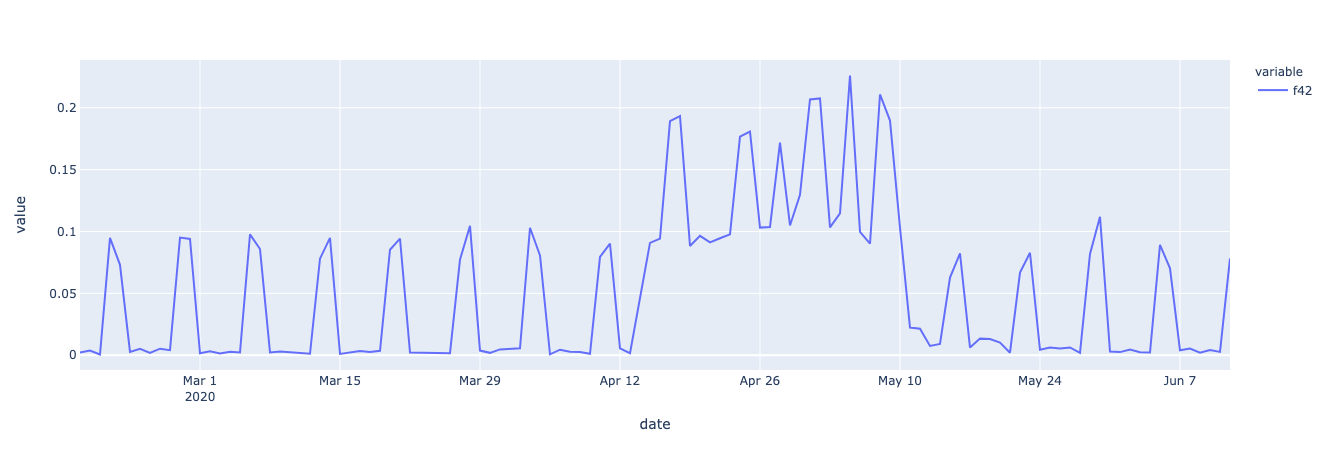

In [9]:
pd.options.plotting.backend = "plotly"

dist_drift = data.groupby('date')[feature].apply(categorical_chisquare)
dist_drift.plot()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

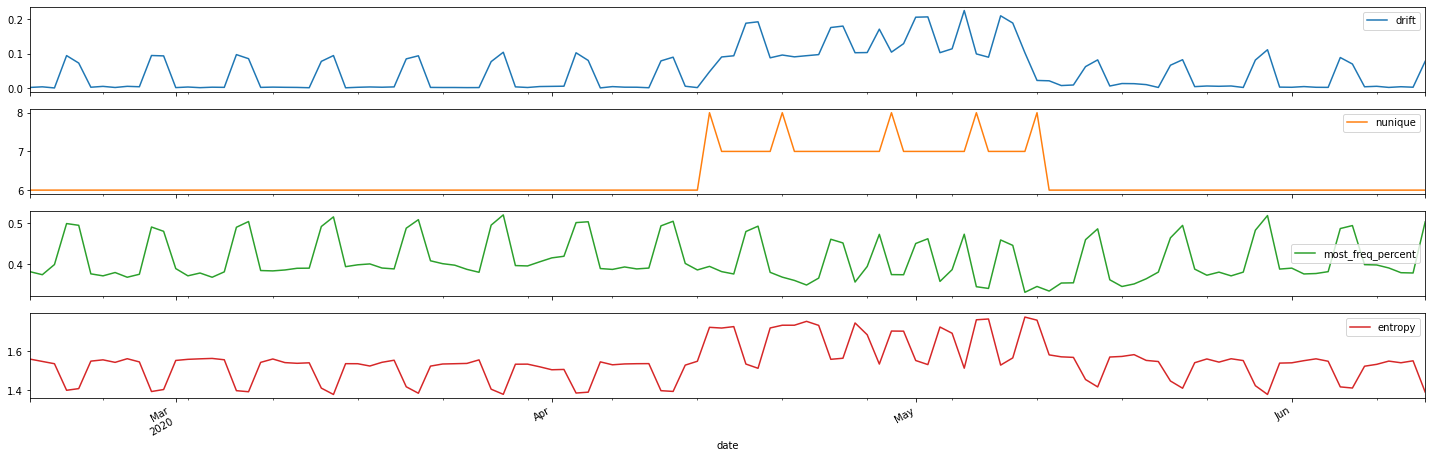

In [10]:
pd.options.plotting.backend = "matplotlib"

pd.concat([dist_drift.rename('drift'), feature_stats], axis=1).plot(subplots=True, figsize=(25, 8))

#### See the change in the distribution

let's see the detected change by comparing the distribution in the detected period versus the da

<AxesSubplot:xlabel='f42', ylabel='count'>

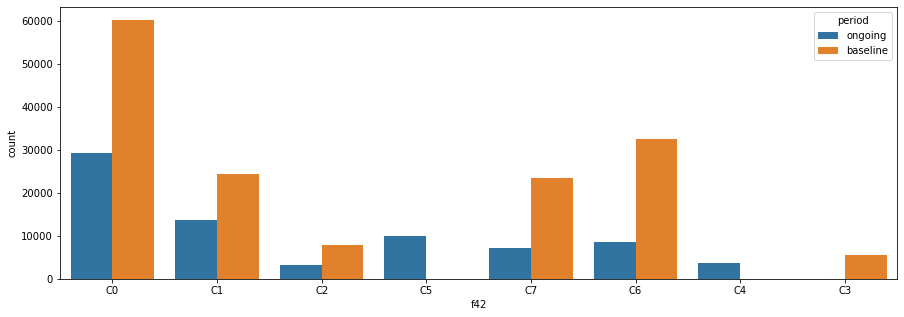

In [11]:
start_date = '2020-04-16'
end_date =  '2020-05-10'

period_data = data.loc[data['date'].between(start_date, end_date), feature]
base = baseline[feature]

tmp = pd.concat([period_data, base], keys=['ongoing','baseline'], names=['period']).reset_index('period')
ax = plt.figure(figsize=(15,5)).gca()
sns.countplot(data=tmp, x=feature, hue='period', ax=ax)

### Numeric Feature

In [12]:
feature = 'f21'

In [13]:
baseline[feature].describe()

count    153870.000000
mean        139.282199
std         243.607204
min           0.000000
25%           6.583300
50%          23.016700
75%         159.050000
max        1438.650000
Name: f21, dtype: float64

#### Simple Statistics
* Mean
* Standard Deviation
* Min
* Max
* ...

In [14]:
feature_stats = data.groupby('date')[feature].agg(['mean', 'max', 'min', 'std'])
feature_stats.head()

mean        max  min         std
date                                              
2020-02-18  142.116376  1433.9333  0.0  242.273676
2020-02-19  139.616793  1437.1500  0.0  241.207967
2020-02-20  136.532997  1429.2000  0.0  238.391358
2020-02-21  129.119317  1410.6667  0.0  246.747712
2020-02-22  130.054171  1413.6667  0.0  250.307110

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

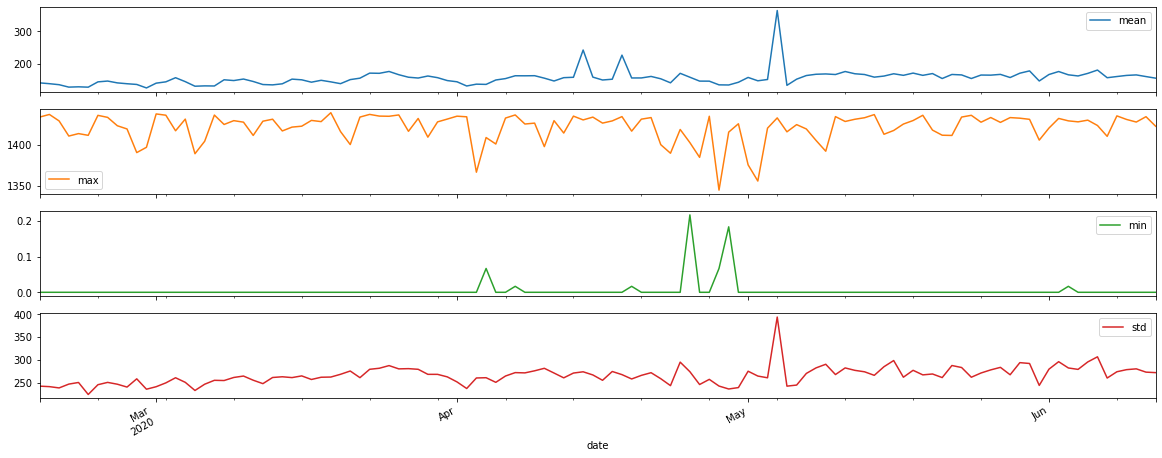

In [15]:
pd.options.plotting.backend = "matplotlib"

feature_stats.plot(subplots=True, figsize=(20,8))

#### Changes in the data distribution - Chi Square

For simplicity - we use the same distance metric - Chi Square. To use this metric with numeric values we first need to discretize the values (binning). Note that Chi Square ignore 'distance' between bins. We use simple binnig procedure - discrete low cardinality values will keep their values and high continues (high cardinality) features will be discretize using quantile binning (using pandas qcut)

In [16]:
feature_binning = pd.qcut(baseline[feature], 100)
feature_binning.head(3)

id
3001          (6.033, 6.1]
3002    (606.643, 680.551]
3003      (29.483, 32.017]
Name: f21, dtype: category
Categories (100, interval[float64]): [(-0.001, 1.333] < (1.333, 5.183] < (5.183, 5.317] < (5.317, 5.383] ... (756.487, 878.557] < (878.557, 1031.233] < (1031.233, 1196.749] < (1196.749, 1438.65]]

In [17]:
baseline_distribution = feature_binning.value_counts(normalize=True).sort_index()
inteval_idx = feature_binning.cat.categories

def numric_chisquare(obs, exp_dist=baseline_distribution, inteval_idx=inteval_idx):
    obs_dist = pd.cut(obs, bins=inteval_idx).value_counts(normalize=True).sort_index()
    obs_dist = obs_dist.reindex(exp_dist.index).fillna(0)
    r = chisquare(f_obs=obs_dist, f_exp=exp_dist)
    return r.statistic

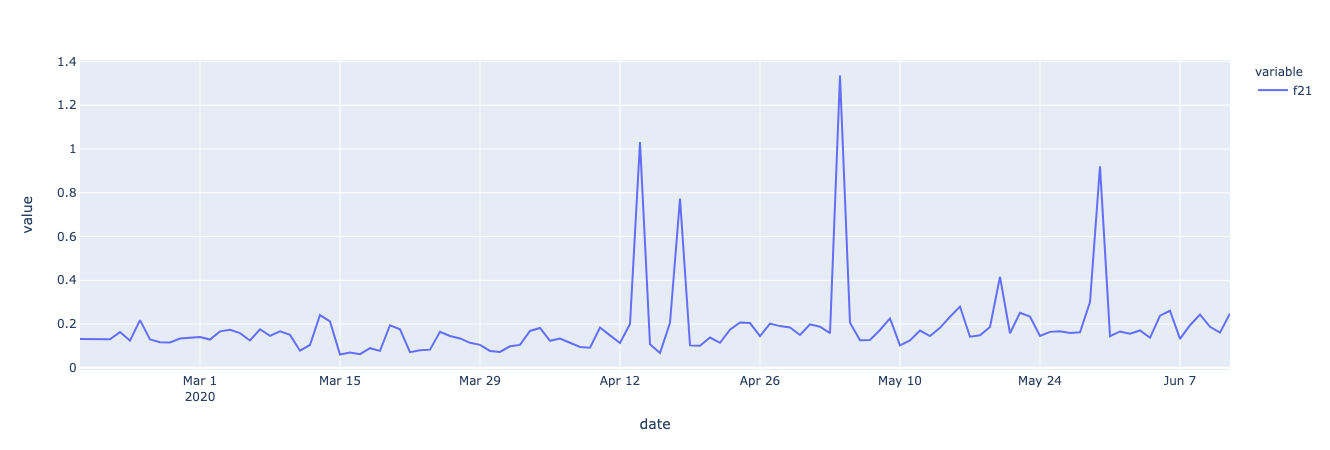

In [18]:
pd.options.plotting.backend = "plotly"

dist_drift = data.groupby('date')[feature].apply(numric_chisquare)
dist_drift.plot()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

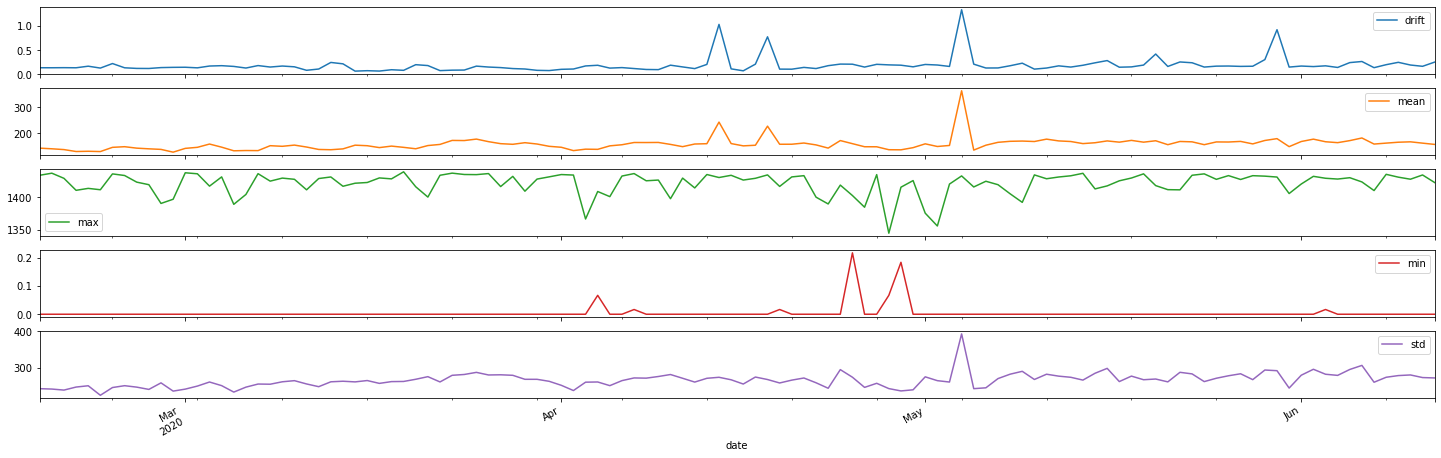

In [19]:
pd.options.plotting.backend = "matplotlib"

pd.concat([dist_drift.rename('drift'), feature_stats], axis=1).plot(subplots=True, figsize=(25, 8))

#### See the change in the distribution

<AxesSubplot:>

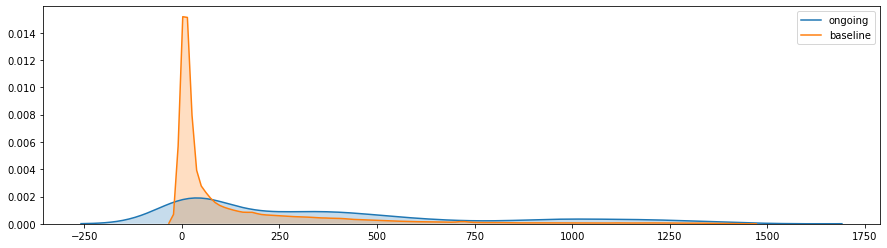

In [20]:
start_date = '2020-05-04'
end_date =  '2020-05-04'

period_data = data.loc[data['date'].between(start_date, end_date), feature]
base = baseline[feature]

ax = plt.figure(figsize=(15,4)).gca()

sns.kdeplot(period_data, shade=True, label='ongoing')
sns.kdeplot(baseline[feature], shade=True, label='baseline')

# tmp = pd.concat([period_data, base], keys=['ongoing','baseline'], names=['period']).reset_index('period')
# sns.distplot(data=tmp, x=feature, hue='period', ax=ax)

## Run on all features

* numeric features: 1 - 32
* categorical features : 33 - 45
* binary features: : 46 - 61

In [21]:
numeric_features = [f"f{i}" for i in range(1, 33)]
categorical_features = [f"f{i}" for i in range(33, 46)]
binary_features = [f"f{i}" for i in range(47, 62)]

In [22]:
features_dist_drift = dict()

### Categorical features

In [23]:
print(f"{len(categorical_features)} features")
for feature in categorical_features:
    baseline_distribution = baseline[feature].value_counts(normalize=True)
    dist_drift = data.groupby('date')[feature].apply(categorical_chisquare, exp_dist=baseline_distribution)
    features_dist_drift[feature] = dist_drift

13 features


### Binary features

* treat similar to categorical

In [24]:
print(f"{len(binary_features)} features")
for feature in binary_features:
    baseline_distribution = baseline[feature].value_counts(normalize=True)
    dist_drift = data.groupby('date')[feature].apply(categorical_chisquare, exp_dist=baseline_distribution)
    features_dist_drift[feature] = dist_drift

15 features


### Numeric features

need to be discretize. We use the following heuristic:
* features with less than 50 unique values - as is (bin per value)
* features with up to 1000 values
    * if first 10 values represent more than 70 percent of the data:
        * we use these 10 values as bins (bin per value) and split the rest of the data to 10 bins
    * if first 10 values represent less than 70 percent of the data - # of bins = 10% of the unique values
* features with more than 1000 values - 100 bins

> Note: This heuristic was selected by knowing the features values, semantic and behavior and not necessarily will work for other features

In [25]:
numeric_nunique = baseline[numeric_features].nunique()
numeric_nunique.sort_values()

f13        4
f16        5
f17        6
f19        9
f32       10
f7        11
f2        16
f20       21
f11       30
f28       31
f5        31
f15       31
f10       38
f8        50
f6       141
f4       148
f25      149
f29      159
f3       171
f23      176
f9       184
f24      260
f30      279
f22      368
f31      370
f1       543
f27     1124
f26     1140
f14     3176
f12     4618
f18     5137
f21    34140
dtype: int64

In [26]:
tmp = numeric_nunique[numeric_nunique.between(1, 100)]
print(f"{len(tmp)} features")
for feature in tmp.index:
    baseline_distribution = baseline[feature].value_counts(normalize=True)
    dist_drift = data.groupby('date')[feature].apply(categorical_chisquare, exp_dist=baseline_distribution)
    features_dist_drift[feature] = dist_drift

14 features


In [27]:
tmp = numeric_nunique[numeric_nunique.between(101, 1000)]
print(f"{len(tmp)} features")
for feature in tmp.index:
    top_percent = baseline[feature].value_counts(normalize=True).sort_index().head(10).sum()
    
    if top_percent > 0.70:
        bins = baseline[feature].value_counts(normalize=True).sort_index().head(10).index.tolist()
        top_bin = max(bins)
        feature_tail = baseline.loc[baseline[feature]>top_bin, feature]
        feature_binning, bins2 = pd.qcut(feature_tail, q=10, duplicates='drop', retbins=True)
        new_bins = bins + list(bins2)
        new_bins[-1] = np.inf
        feature_binning = pd.cut(baseline[feature], bins=new_bins, include_lowest=True, right=False)
    else:
        feature_binning = pd.qcut(baseline[feature], int(numeric_nunique[feature]/10))

    baseline_distribution = feature_binning.value_counts(normalize=True).sort_index()
    inteval_idx = feature_binning.cat.categories

    dist_drift = data.groupby('date')[feature].apply(numric_chisquare, exp_dist=baseline_distribution, inteval_idx=inteval_idx)
    features_dist_drift[feature] = dist_drift

12 features


In [28]:
tmp = numeric_nunique[numeric_nunique>1000]
print(f"{len(tmp)} features")
for feature in tmp.index:  
    feature_binning = pd.qcut(baseline[feature], 100, duplicates='drop')

    baseline_distribution = feature_binning.value_counts(normalize=True).sort_index()
    inteval_idx = feature_binning.cat.categories

    dist_drift = data.groupby('date')[feature].apply(numric_chisquare, exp_dist=baseline_distribution, inteval_idx=inteval_idx)
    features_dist_drift[feature] = dist_drift

6 features


In [29]:
dist_drift_df = pd.DataFrame(features_dist_drift)
print(dist_drift_df.shape)
dist_drift_df.head(2)

(116, 60)


f33       f34       f35       f36       f37       f38  \
date                                                                     
2020-02-18  0.000270  0.000866  0.006404  0.008558  0.006873  0.011227   
2020-02-19  0.002632  0.000894  0.003482  0.008745  0.005154  0.008658   

                 f39       f40       f41       f42  ...       f25       f29  \
date                                                ...                       
2020-02-18  0.010533  0.000147  0.001713  0.002051  ...  0.071049  0.002432   
2020-02-19  0.006012  0.001513  0.002095  0.003790  ...  0.057175  0.004114   

                 f30       f31       f12       f14       f18       f21  \
date                                                                     
2020-02-18  0.013609  0.003206  0.031683  0.004367  0.010818  0.131171   
2020-02-19  0.009753  0.005131  0.032941  0.002073  0.008638  0.130877   

                 f26       f27  
date                            
2020-02-18  0.007604  0.009361  
2020-02-19  0.008722  0.008227  

[2 rows x 60 columns]

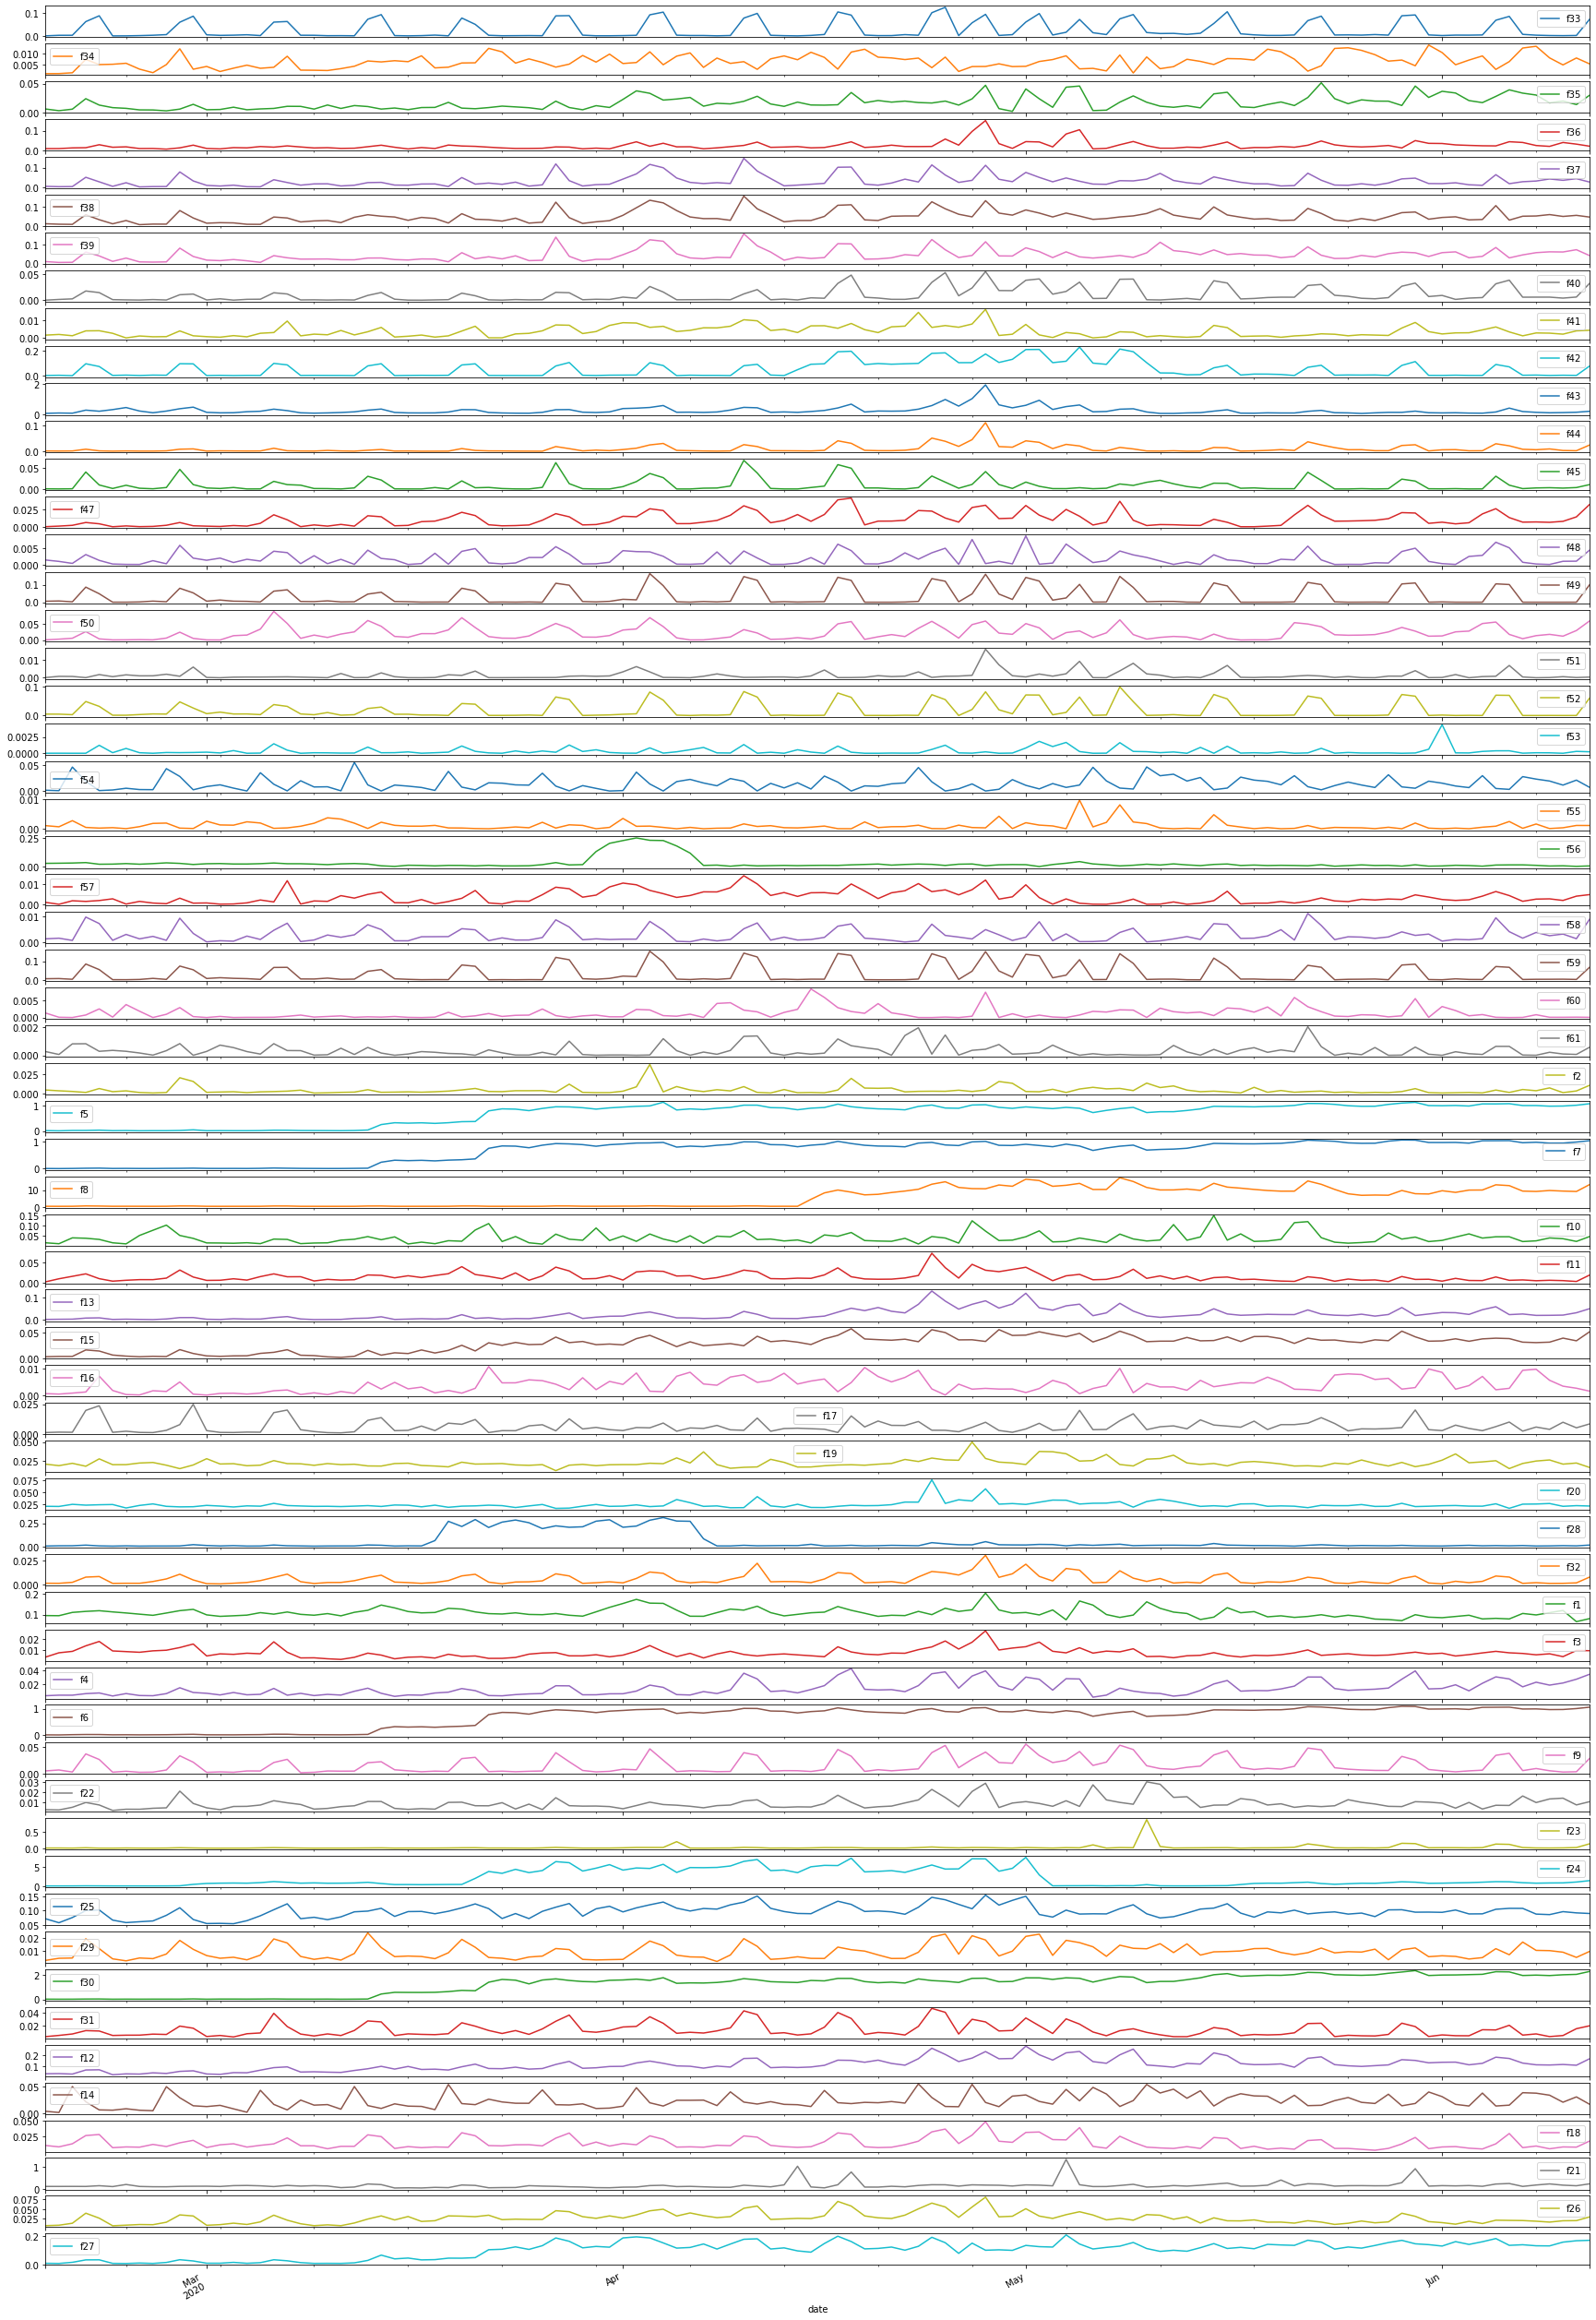

In [30]:
pd.options.plotting.backend = "matplotlib"

axes = dist_drift_df.plot(figsize=(30,50), subplots=True)

# mask = (dist_drift_df.index > '2020-04-16') & (dist_drift_df.index < '2020-05-05')
# for ax in axes:
#     ax.fill_between(dist_drift_df.index, 0, ax.get_ylim()[1], where=mask, color='red', alpha=0.1)

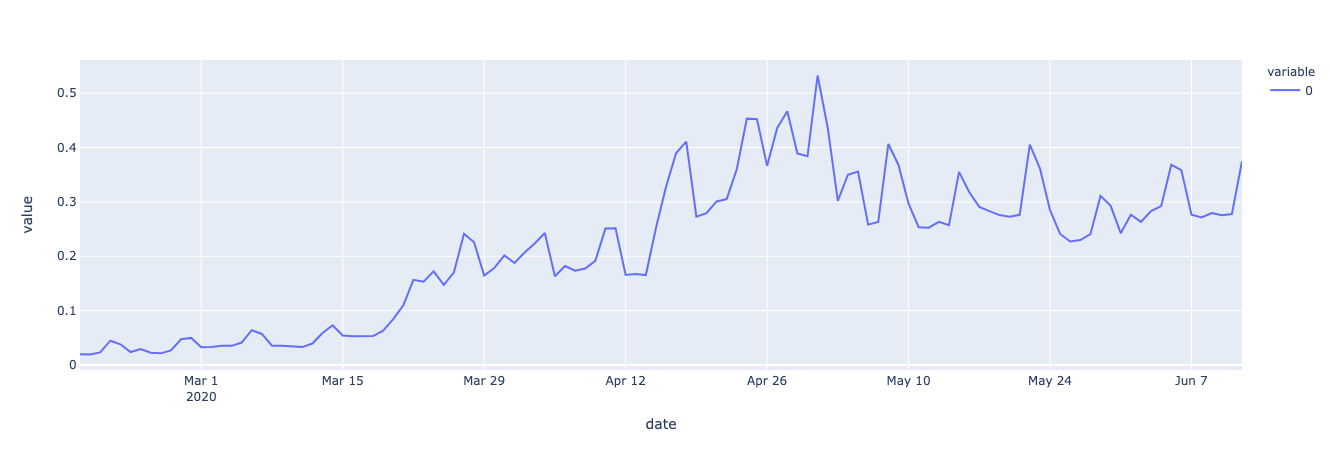

In [31]:
pd.options.plotting.backend = "plotly"

data_drift = dist_drift_df.mean(axis=1)
data_drift.plot()

# Discriminator

Training a model that try to classify if the data is baseline or ongoing

## Prepare data to modeling

In [32]:
X_base = baseline.drop(columns=['date', 'prediction_probability', 'label'])
print(X_base.shape)
X_base.head(1)

(153870, 61)


f1   f2   f3   f4   f5   f6   f7  f8  f9  f10  ...  f52  f53  f54  f55  \
id                                                    ...                       
3001  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN   0    0  ...    1  0.0  0.0    0   

      f56  f57  f58  f59  f60  f61  
id                                  
3001  0.0    0    0  0.0    0    0  

[1 rows x 61 columns]

In [33]:
X = data.drop(columns=['date', 'prediction_probability', 'label'])
print(X.shape)
X.head(2)

(544950, 61)


f1   f2   f3   f4   f5   f6   f7  f8   f9  f10  ...  f52  f53  f54  \
id                                                        ...                  
1494010  0.0  0.0  0.0  0.0  1.0  2.0  1.0 NaN  0.0  0.0  ...    1  0.0  0.0   
1494050  0.0  0.0  1.0  2.0  2.0  4.0  1.0 NaN  0.0  0.0  ...    0  0.0  0.0   

         f55  f56  f57  f58  f59  f60  f61  
id                                          
1494010    0  0.0    0    0  0.0    0    0  
1494050    1  0.0    0    0  0.0    1    0  

[2 rows x 61 columns]

### numeric features

#### Fill missing values

> Note - Filling missing values requires some domain knowledge. In this case, given the meaning of the feature, filling missing values with zero is reasonable approach

In [34]:
nans = X_base.isna().mean()
nans[nans>0]

f8     0.714727
f19    0.136615
f20    0.136615
dtype: float64

In [35]:
X_base['f8'] = X_base['f8'].fillna(0)
X_base['f19'] = X_base['f19'].fillna(0)
X_base['f20'] = X_base['f20'].fillna(0)

X['f8'] = X['f8'].fillna(0)
X['f19'] = X['f19'].fillna(0)
X['f20'] = X['f20'].fillna(0)

In [36]:
X_base.isna().any(axis=None), X.isna().any(axis=None)

(False, False)

### Categorical features
Merge values in sparse feature and get dummies

In [37]:
X_base[categorical_features].nunique().sort_values(ascending=False).head()

f43    192
f38     24
f39     19
f37     14
f36     10
dtype: int64

feature *'f43'* have 192 unique categories with a lot of small portion categories. We'll take the top 20 categories which represent 80% of the data and merge all others to 'Other' category.

In [38]:
X_base['f43'].value_counts(normalize=True).head(20).cumsum()

C207    0.291343
C29     0.378417
C70     0.452011
C144    0.520732
C35     0.563957
C12     0.603314
C68     0.642432
C151    0.661734
C51     0.679684
C44     0.696919
C41     0.713134
C220    0.728687
C2      0.743303
C61     0.756886
C9      0.769890
C95     0.781705
C93     0.791129
C174    0.800149
C179    0.809138
C157    0.817976
Name: f43, dtype: float64

In [39]:
keep_values = X_base['f43'].value_counts(normalize=True).head(20).index

X_base['f43'] = X_base['f43'].where(X_base['f43'].isin(keep_values), 'Other')
X['f43'] = X['f43'].where(X['f43'].isin(keep_values), 'Other')

In [40]:
# X_base['f43'].value_counts(normalize=True)

get dummies

In [41]:
X_base_dummies = pd.get_dummies(X_base, columns=categorical_features)
X_dummies = pd.get_dummies(X, columns=categorical_features)

print(X_dummies.shape)
X_dummies.head(2)

(544950, 179)


f1   f2   f3   f4   f5   f6   f7   f8   f9  f10  ...  f43_C70  \
id                                                         ...            
1494010  0.0  0.0  0.0  0.0  1.0  2.0  1.0  0.0  0.0  0.0  ...        0   
1494050  0.0  0.0  1.0  2.0  2.0  4.0  1.0  0.0  0.0  0.0  ...        0   

         f43_C9  f43_C93  f43_C95  f43_Other  f44_C0  f44_C1  f44_C2  f45_C0  \
id                                                                             
1494010       0        0        0          0       0       0       1       1   
1494050       0        0        0          0       0       1       0       1   

         f45_C1  
id               
1494010       0  
1494050       0  

[2 rows x 179 columns]

## Train models

Train model and measure how well the model distinguish between baseline data and ongoing data

In [42]:
def dataSimilarity(df0, df1):
    model = DecisionTreeClassifier(min_samples_leaf=10)
    # model = RandomForestClassifier(min_samples_leaf=10, n_jobs=-1)

    df0['dataset'] = 0
    df1['dataset'] = 1
    
    ndf0 = df0.shape[0]
    ndf1 = df1.shape[0]
    
    if ndf0 > ndf1:
        df0 = df0.sample(n=ndf1, random_state=555)
    else:
        df1 = df1.sample(n=ndf0, random_state=555)
    
    all_data = pd.concat([df0,df1]).fillna(0)
    X_tmp = all_data.drop(columns='dataset')
    y_tmp = all_data['dataset']
    
    auc_scores = np.mean(cross_val_score(model, X_tmp, y_tmp, scoring='roc_auc', cv=5, n_jobs=-1))
    norm_score = (max(np.mean(auc_scores), 1-np.mean(auc_scores))-0.5)*2
    model.fit(X_tmp, y_tmp)
    return norm_score, model

In [43]:
days_grpby = data.groupby('date')

scores = dict()
models = dict()
for date, idx in tqdm(days_grpby.groups.items()):
    date_data = X_dummies.loc[idx, :]
    score, date_model = dataSimilarity(df0=X_base_dummies, df1=date_data)
    scores[date] = score
    models[str(date.date())] = date_model
X_base_dummies = X_base_dummies.drop(columns='dataset', errors='ignore')

100%|██████████| 116/116 [01:26<00:00,  1.35it/s]


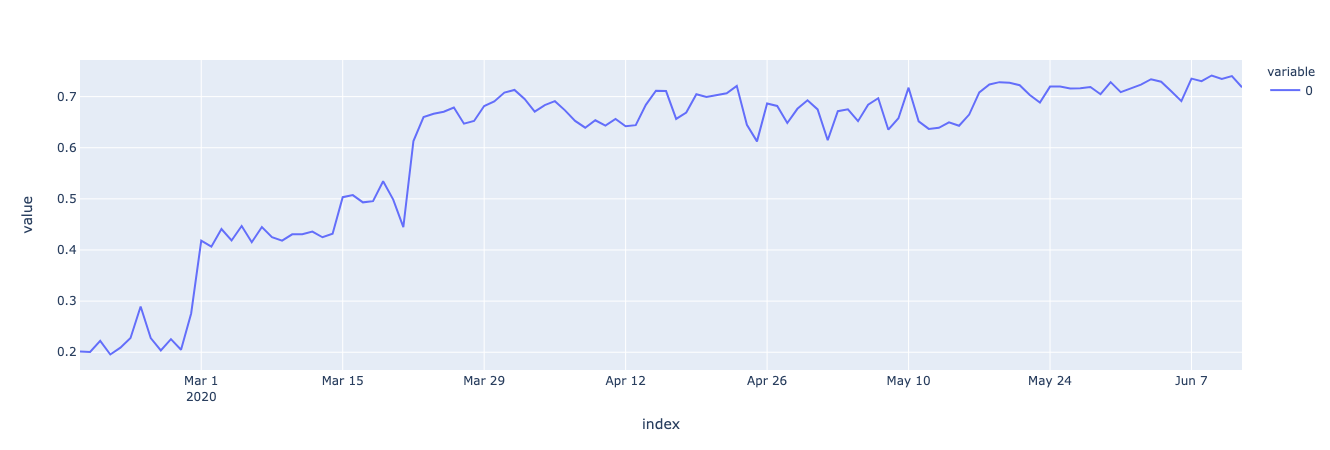

In [44]:
pd.options.plotting.backend = "plotly"

discriminator_drift = pd.Series(scores)
discriminator_drift.plot()

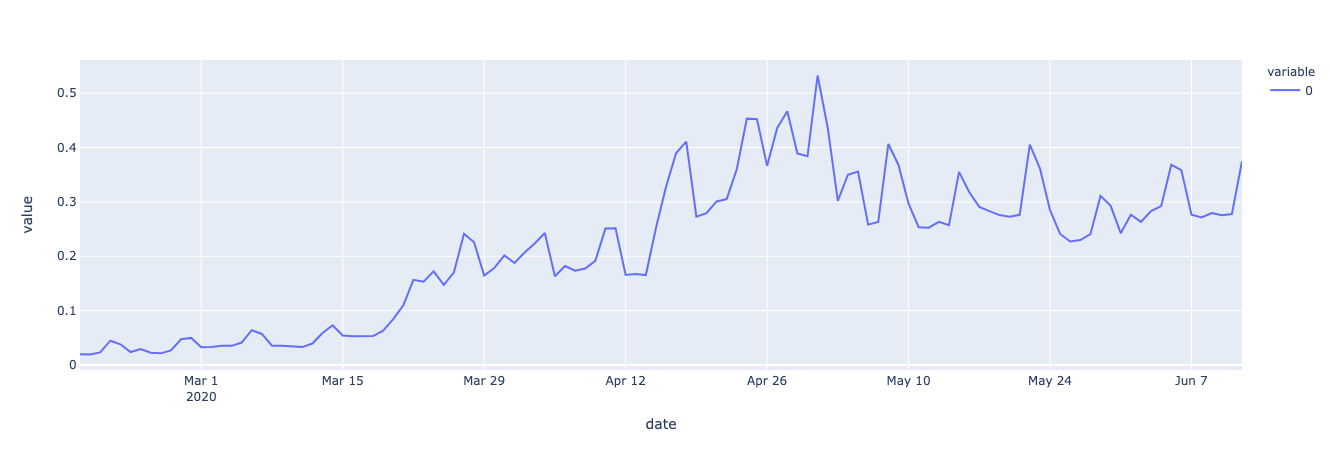

In [45]:
data_drift.plot()

### Investigate what is the change source

In [46]:
tree = models['2020-03-07']

In [47]:
fnames = pd.concat([X_base_dummies.head(1), X_dummies.head(1)]).columns

fi = pd.Series(tree.feature_importances_, index=fnames)
fi.sort_values(ascending=False).head()

f24       0.200014
f21       0.100596
f36_C0    0.090577
f12       0.067270
f25       0.060563
dtype: float64

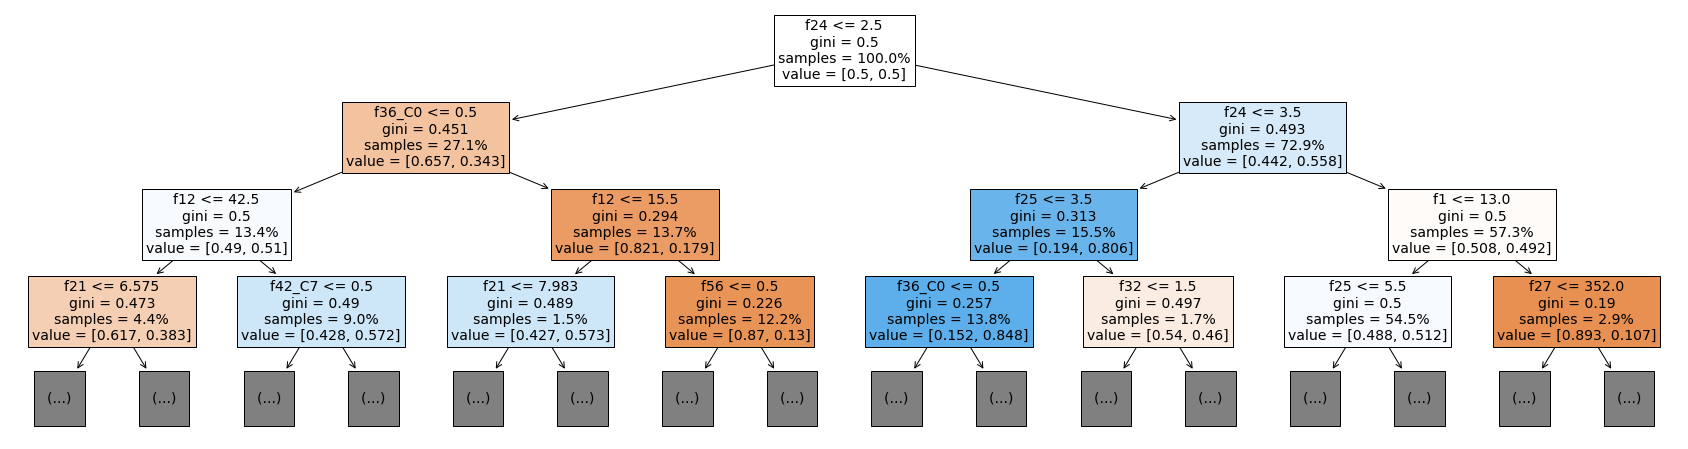

In [48]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,8))
_ = plot_tree(tree, max_depth=3, proportion=True,
              filled=True, feature_names=X_base_dummies.columns, fontsize=14)

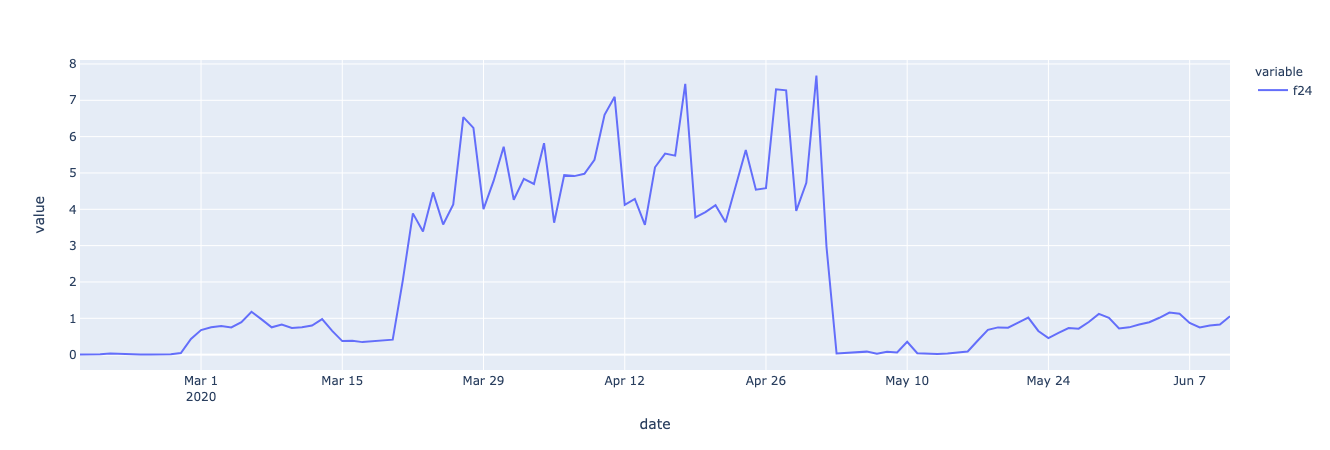

In [49]:
data.groupby('date')['f24'].agg(['mean', 'max', 'min', 'std']).plot()

dist_drift_df['f24'].iloc[:-1].plot()

# PCA

* normalize data using scaler
* fit pca and find principal components (we use here top 5 components)
* transform ongoing data using the fitted pca and monitor principal components

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
sc = MinMaxScaler()
X_base_transformed = sc.fit_transform(X_base_dummies)

In [52]:
pca = PCA()
pca.fit(X_base_transformed)

PCA()

check explained variance as function of the principal components

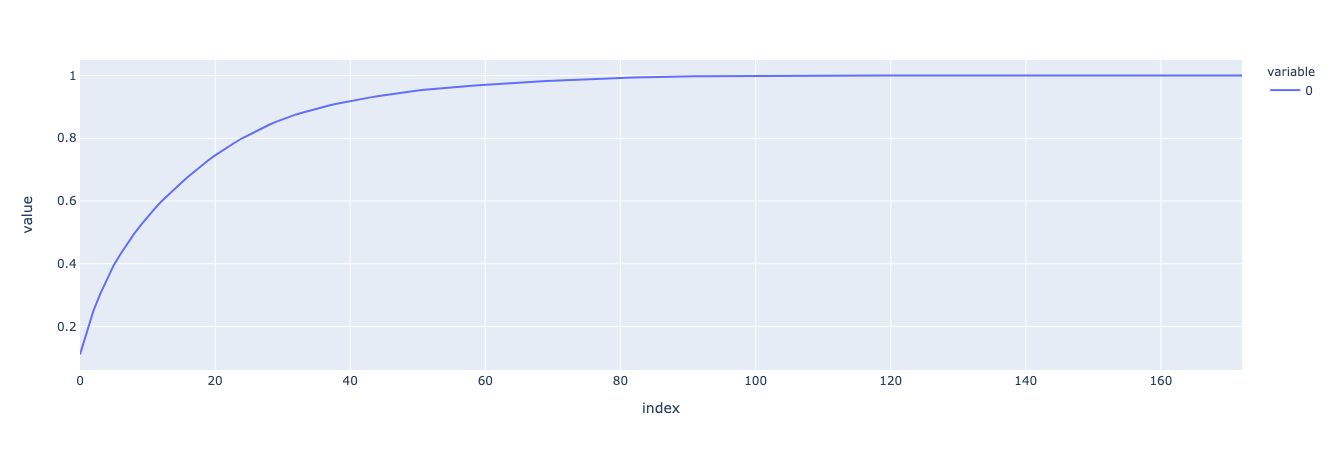

In [53]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot()

## Fit and transform

In [54]:
pca_ = PCA(n_components=5)
pca_.fit(sc.fit_transform(X_base_dummies))

PCA(n_components=5)

In [55]:
# align columns (features) with the baseline columns (difference might occure due to missing/new values)
X_tmp = X_dummies.reindex(columns=X_base_dummies.columns).fillna(0)
pca_results = pca_.transform(sc.transform(X_tmp))
pca_results.shape

df_pca = pd.DataFrame(data=pca_results, index=X_tmp.index, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
print(df_pca.shape)
df_pca.head(2)

(544950, 5)


pc1       pc2       pc3       pc4       pc5
id                                                       
1494010 -0.528359  0.226016 -0.728706  0.940140  0.253562
1494050 -0.831888  0.190898  0.179374  0.281366 -0.452767

In [56]:
pca_drift = df_pca.groupby(data['date']).mean()
print(pca_drift.shape)
pca_drift.head(2)

(116, 5)


pc1       pc2       pc3       pc4       pc5
date                                                        
2020-02-18 -0.037724  0.009494  0.003103  0.065081  0.000738
2020-02-19 -0.028870  0.046048 -0.007053  0.065819 -0.005335

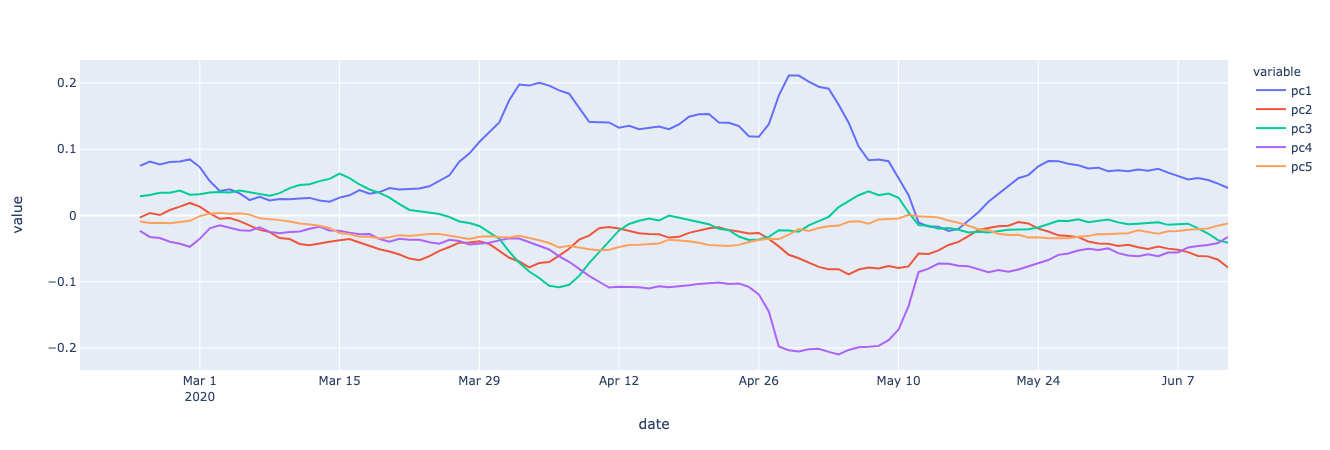

In [57]:
# pca_drift.plot()
pca_drift.rolling(7).mean().plot()

## Aggregate components

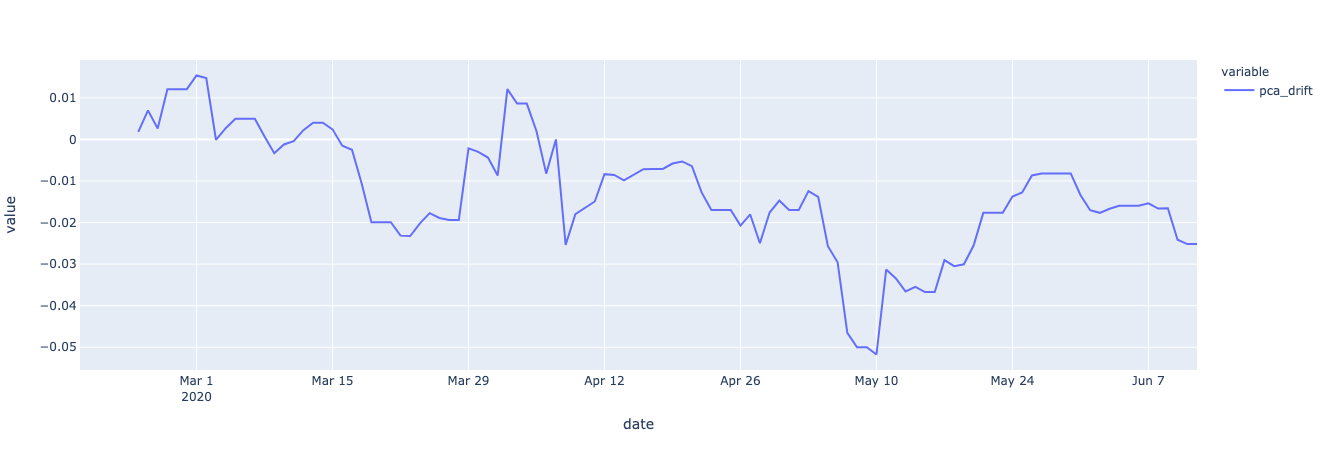

In [58]:
pca_drift.rolling(7).median().mean(axis=1).rename('pca_drift').plot()

In [59]:
# data_drift.rolling(7).mean().rename('data_drift').plot()

---
---
# MNIST Use-case

## Load Data

In [61]:
fpath = 'mnist_data_2.pkl'
fpath = 'https://superwise-public.s3.amazonaws.com/mnist_data_2.pkl'

df_mnist = pd.read_pickle(fpath)
print(df_mnist.shape)
df_mnist.head(2)

(70000, 786)


type    0    1    2    3    4    5    6    7    8  ...  775  776  777  \
0  clean  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  clean  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

   778  779  780  781  782  783  label  
0  0.0  0.0  0.0  0.0  0.0  0.0      5  
1  0.0  0.0  0.0  0.0  0.0  0.0      0  

[2 rows x 786 columns]

In [62]:
df_mnist['type'].value_counts()

clean    60000
noisy    10000
Name: type, dtype: int64

take first 10K images as baseline:

In [63]:
mnist_baseline_X = df_mnist.iloc[:10000, :].drop(columns=['type', 'label'])
mnist_baseline_y = df_mnist.iloc[:10000, :]['label']

mnist_data_X = df_mnist.iloc[10000:, :].drop(columns=['type', 'label'])
mnist_data_y = df_mnist.iloc[10000:, :]['label']

mnist_baseline_X.shape, mnist_data_X.shape

((10000, 784), (60000, 784))

### Show Images example

In [64]:
def plot_digits(images, labels, num_col = 15, num_row=5):
    num = num_col*num_row
    step = int(len(images)/num)

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.2*num_col,1.5*num_row))
    for i in range(num):
        img = images.iloc[i*step].values.reshape(28,28)
        ax = axes[i//num_col, i%num_col]
        ax.imshow(img, cmap='gray')
        ax.set_title('Label: {}'.format(labels.iloc[i*step]))
    plt.tight_layout()
    plt.show()

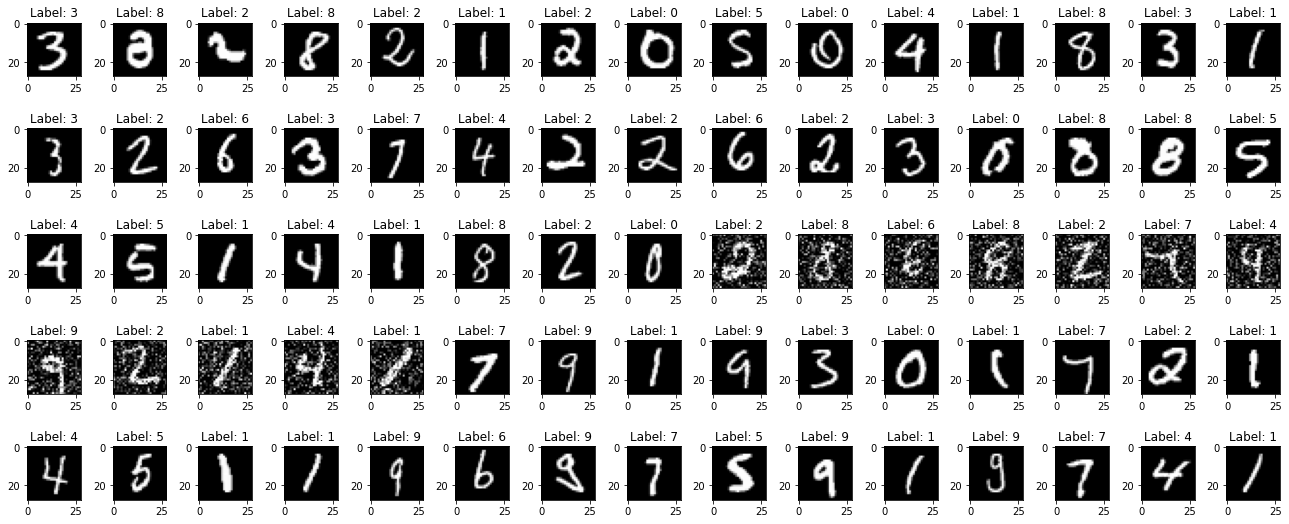

In [65]:
plot_digits(mnist_data_X, mnist_data_y)

## Learn PCA

In [66]:
pca_mnist = PCA()
pca_mnist.fit(mnist_baseline_X)

PCA()

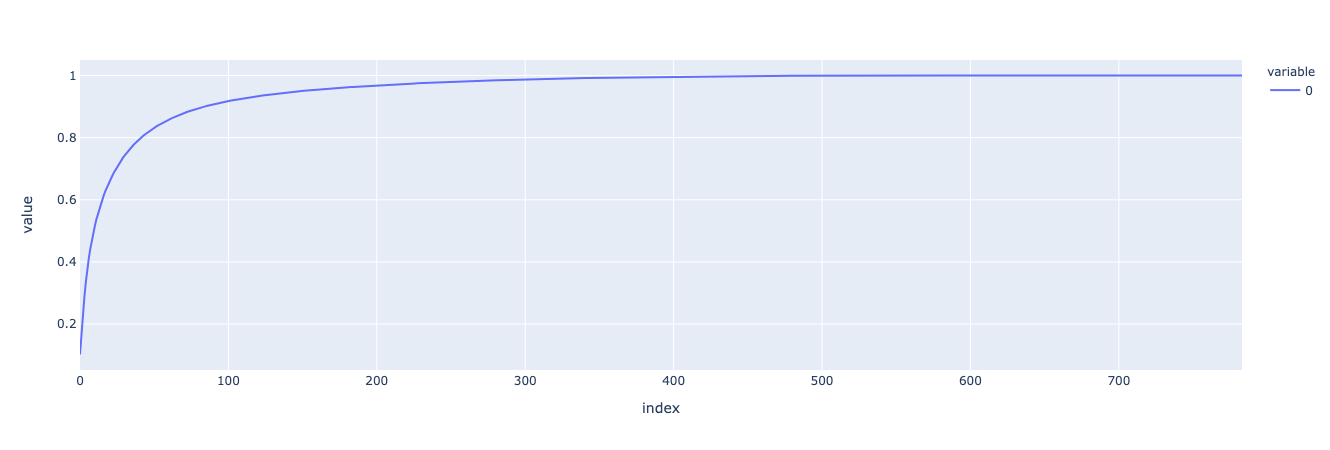

In [67]:
pd.Series(pca_mnist.explained_variance_ratio_).cumsum().plot()

## Fit and transform pca on images data

In [68]:
pca_mnist_20 = PCA(20)
pca_mnist_20.fit(mnist_baseline_X)
pca_results = pca_mnist_20.transform(mnist_data_X)

df_pca = pd.DataFrame(pca_results, columns=[f"pc{i}" for i in range(pca_results.shape[1])])
print(df_pca.shape)
df_pca.head()

(60000, 20)


pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.096055 -2.458155 -2.839963 -2.078529 -0.852615  1.611430  0.016406   
1 -1.342171 -2.124210  2.386373 -1.533003 -0.876508 -1.520939  0.040046   
2 -0.968765  3.467731 -1.400719 -2.227863 -0.841600 -1.338176  2.360479   
3 -1.527863  2.000192 -0.855529 -1.143290  0.174465  2.632600 -1.004336   
4  0.054000  2.921664 -2.668884  1.008398  0.126768 -0.353395 -1.391596   

        pc7       pc8       pc9      pc10      pc11      pc12      pc13  \
0  2.357172  0.289657  0.609799  1.091005 -0.261433  0.085755  1.176686   
1 -0.086697  0.640558 -1.031314  0.805225  0.577994  1.196265 -1.830405   
2  1.198348 -0.557159 -1.828854  0.107859 -0.686391 -0.436137 -1.003507   
3  0.554186  1.676876  0.199963 -1.152877  1.050296 -0.470112 -0.744787   
4  1.268123  0.964829 -0.654100  0.716568 -1.547429  0.344615  1.222117   

       pc14      pc15      pc16      pc17      pc18      pc19  
0 -1.058145 -0.499295 -0.247196  1.228851 -0.926096  0.270649  
1 -1.517213  0.496065 -0.360293 -1.333422 -0.058873  0.553397  
2  0.640728  0.892209  0.159051 -0.820726 -0.922067  0.128018  
3  1.430608  0.070897  0.745073 -0.398215  0.778842  1.058744  
4  0.197324  0.101602 -1.130314 -0.753832  0.744635 -1.577203

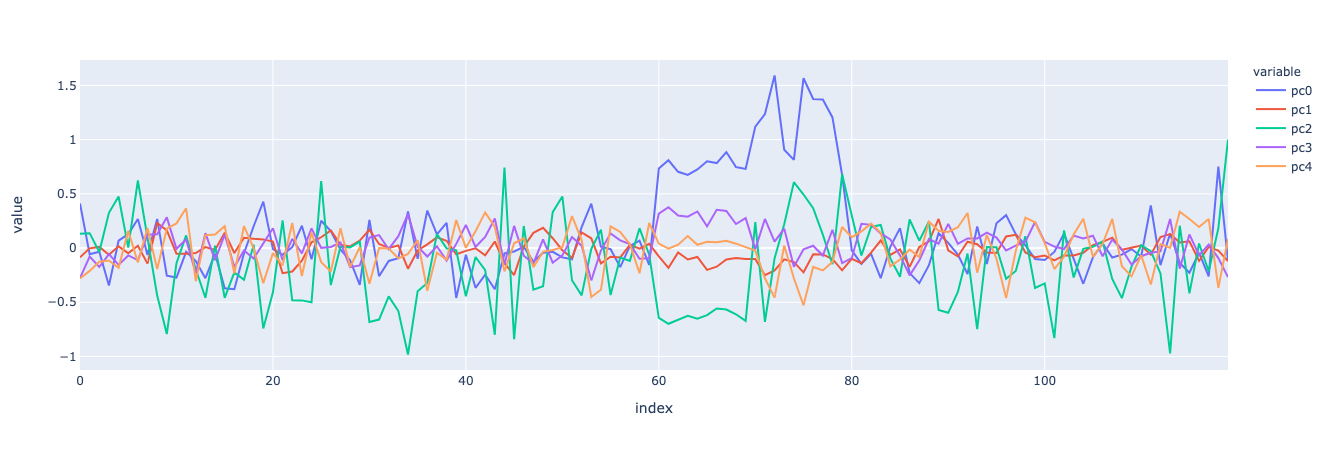

In [75]:
pd.options.plotting.backend = "plotly"

# df_pca.iloc[:, :5].plot()
# df_pca.iloc[:, :5].rolling(500).mean().plot()
df_pca.iloc[:, :5].groupby(np.arange(len(df_pca))//500).mean().plot()

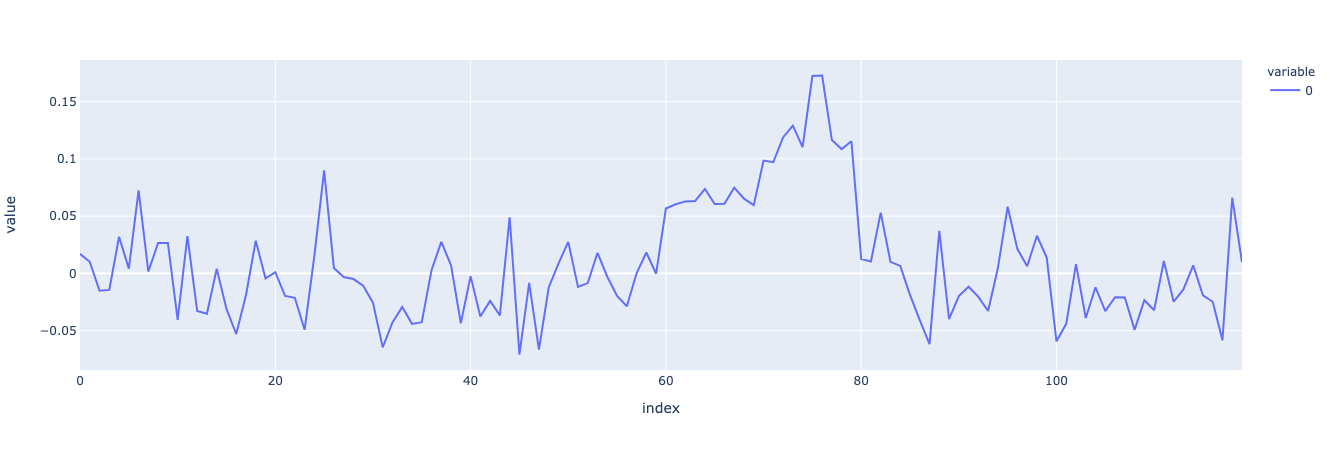

In [76]:
df_pca.mean(axis=1).groupby(np.arange(len(df_pca))//500).mean().plot()